
# Task 1 — UK Road Safety (STATS19) — Collision Severity Classification

This notebook builds an end‑to‑end **classification** pipeline to predict **collision severity** (Fatal / Serious / Slight) using the **UK Department for Transport Road Safety (Collisions 2024)** dataset.

**What we'll do:**
1. Load & inspect the dataset
2. Clean and prepare features
3. Exploratory data analysis (EDA) with visuals
4. Build two models (Logistic Regression, Random Forest)
5. Handle class imbalance (class weights, optional oversampling)
6. Evaluate with precision/recall/F1 and confusion matrices
7. Feature importance



In [32]:

# --- STEP 0: Imports & Settings ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler


plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['figure.dpi'] = 110


In [34]:

# --- STEP 1: Load data ---
PATH = r"C:\Users\fahim\Downloads\Accidents_2024.csv" 

# Read
df = pd.read_csv(PATH, low_memory=False)

print(df.shape)
df.head()


(100927, 44)


,collision_index,collision_year,collision_ref_no,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,collision_severity,number_of_vehicles,...,carriageway_hazards_historic,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,enhanced_severity_collision,collision_injury_based,collision_adjusted_severity_serious,collision_adjusted_severity_slight
0,202417H103224,2024,17H103224,448894,532505,-1.24312,54.68523,17,3,2,...,-1,0,1,2,2,E01011983,3,1,0.000000,1.000000
1,202417M217924,2024,17M217924,452135,519436,-1.19517,54.56747,17,2,2,...,-1,0,1,3,2,E01012061,7,1,1.000000,0.000000
2,202417S204524,2024,17S204524,445427,522924,-1.29837,54.59946,17,3,2,...,0,0,2,1,2,E01012280,-1,0,0.111621,0.888379
3,2024481510889,2024,481510889,533587,181174,-0.07626,51.51371,48,2,1,...,-1,0,1,1,2,E01000005,7,1,1.000000,0.000000
4,2024481563500,2024,481563500,532676,180902,-0.08948,51.51148,48,2,1,...,-1,0,1,1,2,E01032739,5,1,1.000000,0.000000


In [57]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100927 entries, 0 to 100926
Data columns (total 44 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   collision_index                                   100927 non-null  object 
 1   collision_year                                    100927 non-null  int64  
 2   collision_ref_no                                  100927 non-null  object 
 3   location_easting_osgr                             100927 non-null  int64  
 4   location_northing_osgr                            100927 non-null  int64  
 5   longitude                                         100927 non-null  float64
 6   latitude                                          100927 non-null  float64
 7   police_force                                      100927 non-null  int64  
 8   collision_severity                                100927 non-null  int64  
 9   numb

In [36]:

# --- STEP 2: Basic cleaning ---
# Replace placeholder values with NaN for certain columns commonly having -1
for col in ['light_conditions', 'speed_limit']:
    if col in df.columns:
        df[col] = df[col].replace({-1: np.nan})

# Confirm target variable
target_col = 'collision_severity'  # 1=fatal, 2=serious, 3=slight
assert target_col in df.columns, f"Target column '{target_col}' not found!"

# Choose features
feature_cols = [
    'weather_conditions','light_conditions','road_type','speed_limit',
    'number_of_vehicles','number_of_casualties','urban_or_rural_area','day_of_week'
]
missing_features = [c for c in feature_cols if c not in df.columns]
assert not missing_features, f"Missing expected columns: {missing_features}"

X = df[feature_cols].copy()
y = df[target_col].copy()

severity_labels = {1:'Fatal', 2:'Serious', 3:'Slight'}
print("Class distribution (%):\n", y.map(severity_labels).value_counts(normalize=True).mul(100).round(2))


Class distribution (%):
 collision_severity
Slight     75.16
Serious    23.35
Fatal       1.49
Name: proportion, dtype: float64


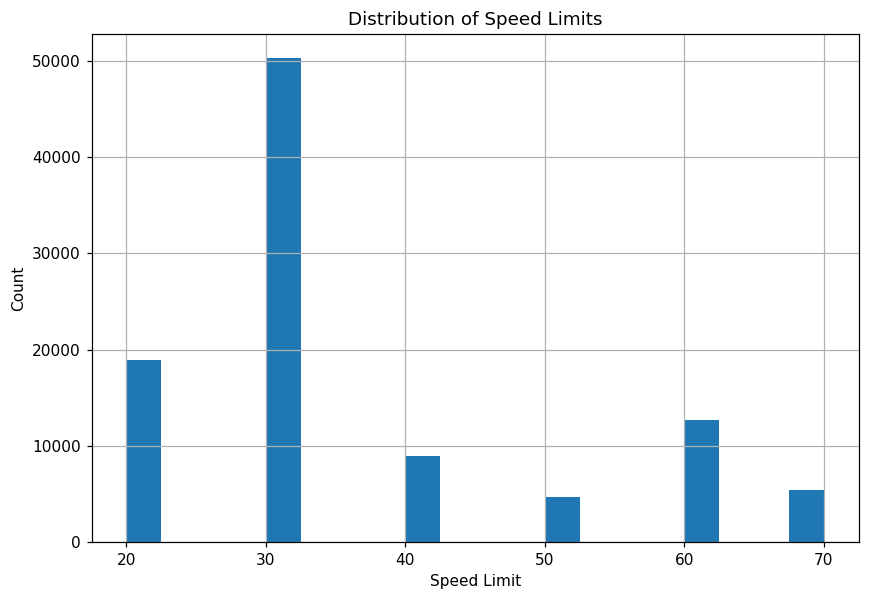

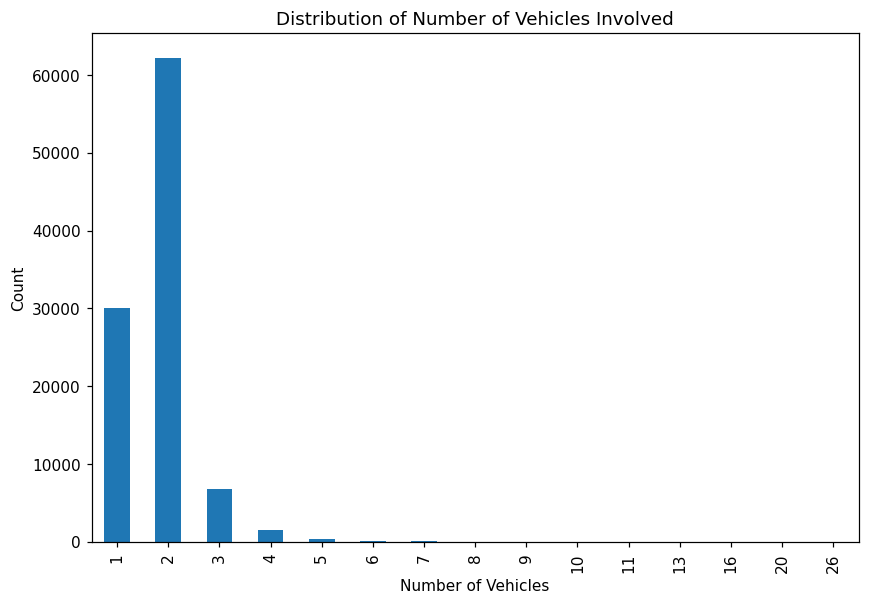

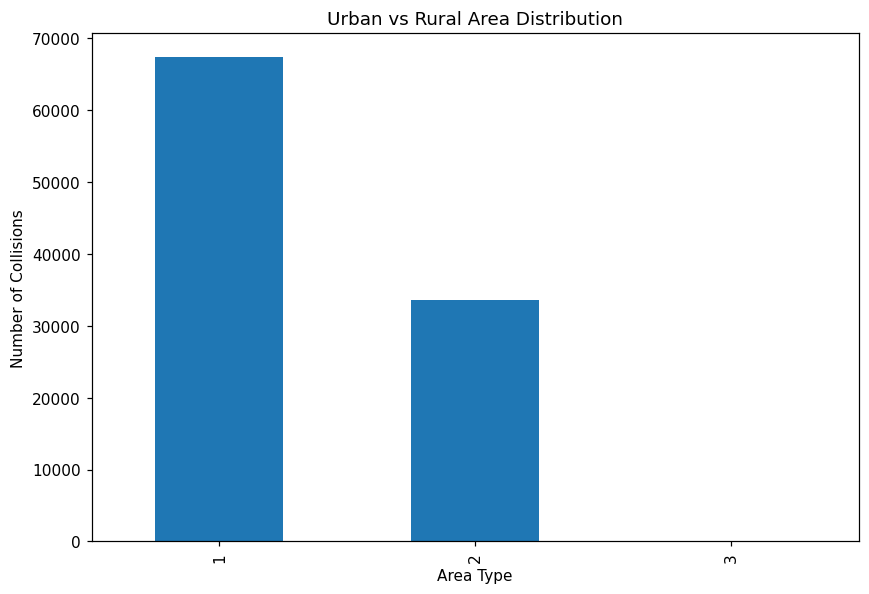

In [71]:
df['speed_limit'].hist(bins=20)
plt.title('Distribution of Speed Limits')
plt.xlabel('Speed Limit')
plt.ylabel('Count')
plt.show()

veh_counts = df['number_of_vehicles'].value_counts().sort_index()
veh_counts.plot(kind='bar')
plt.title('Distribution of Number of Vehicles Involved')
plt.xlabel('Number of Vehicles')
plt.ylabel('Count')
plt.show()

# Urban vs Rural distribution
df['urban_or_rural_area'].value_counts().plot(kind='bar')
plt.title('Urban vs Rural Area Distribution')
plt.xlabel('Area Type')
plt.ylabel('Number of Collisions')
plt.show()

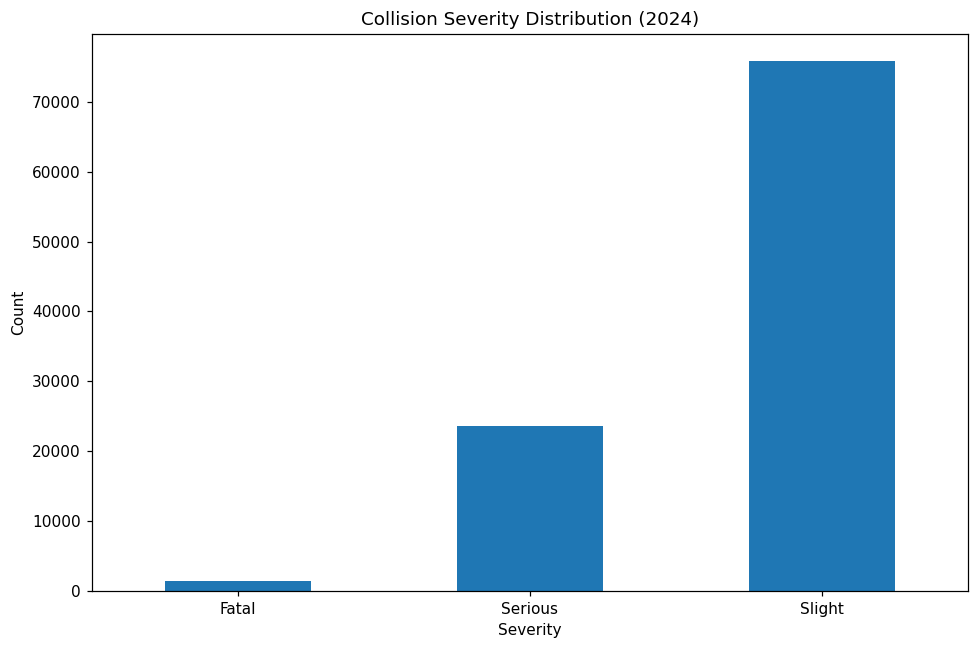

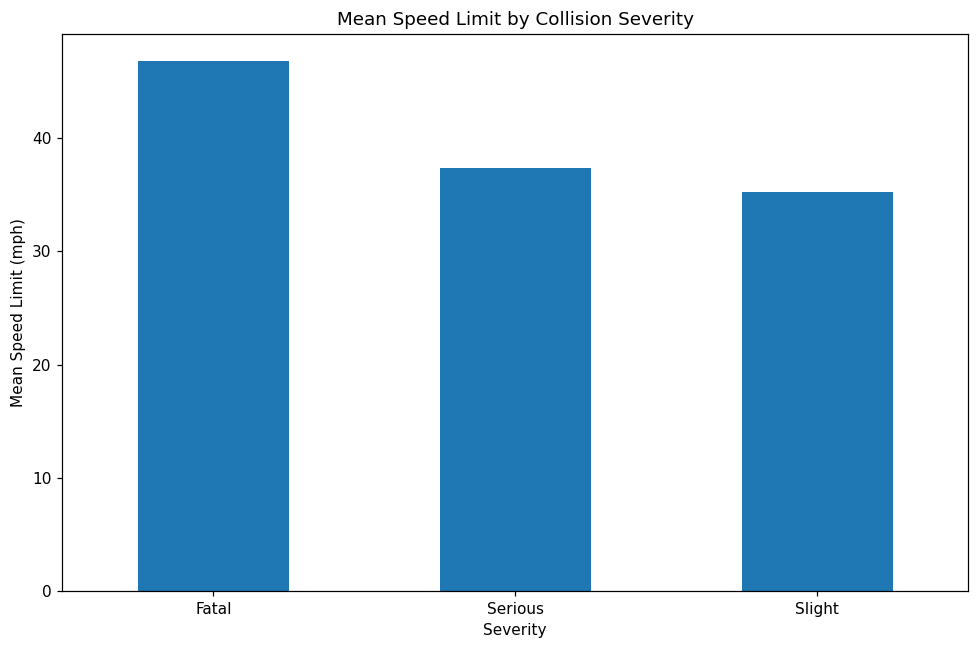

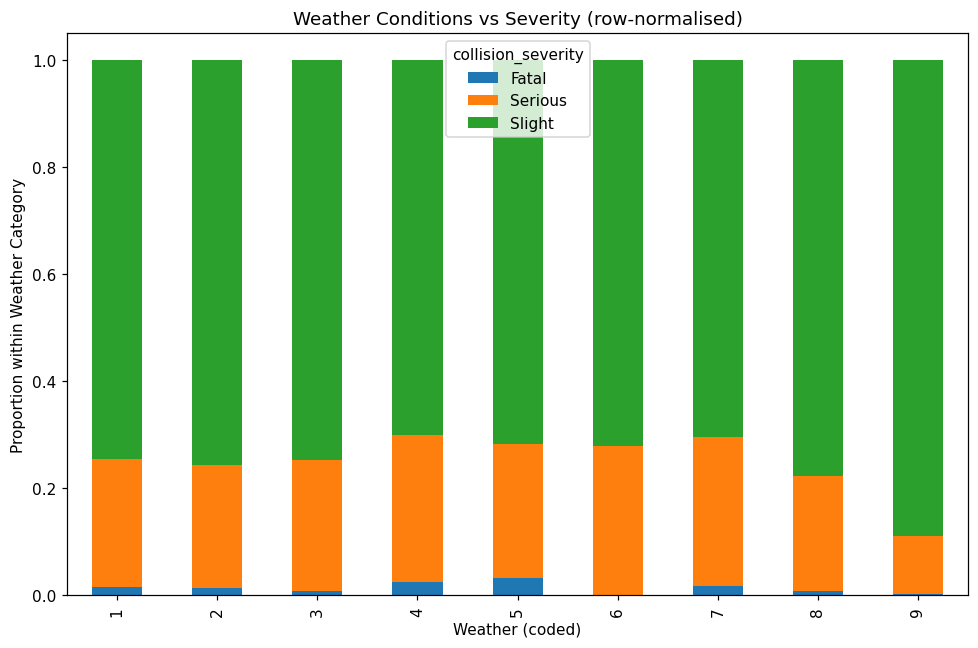

In [38]:

# --- STEP 3: EDA and basic visuals ---

# Distribution of target
counts = y.map(severity_labels).value_counts().reindex(['Fatal','Serious','Slight'])
ax = counts.plot(kind='bar', rot=0)
ax.set_title('Collision Severity Distribution (2024)')
ax.set_xlabel('Severity'); ax.set_ylabel('Count')
plt.tight_layout(); plt.show()

# Mean speed limit by severity
tmp = pd.DataFrame({'speed_limit': X['speed_limit'], 'severity': y.map(severity_labels)}).dropna()
mean_speed = tmp.groupby('severity')['speed_limit'].mean().reindex(['Fatal','Serious','Slight'])
ax = mean_speed.plot(kind='bar', rot=0)
ax.set_title('Mean Speed Limit by Collision Severity')
ax.set_xlabel('Severity'); ax.set_ylabel('Mean Speed Limit (mph)')
plt.tight_layout(); plt.show()

# Weather vs severity (row-normalised proportions)
ct = pd.crosstab(X['weather_conditions'], y.map(severity_labels), normalize='index')
ax = ct.plot(kind='bar', stacked=True)
ax.set_title('Weather Conditions vs Severity (row-normalised)')
ax.set_xlabel('Weather (coded)'); ax.set_ylabel('Proportion within Weather Category')
plt.tight_layout(); plt.show()


In [40]:

# --- STEP 4: Train/Test split and preprocessing ---
numeric_features = ['speed_limit','number_of_vehicles','number_of_casualties']
categorical_features = ['weather_conditions','light_conditions','road_type','urban_or_rural_area','day_of_week']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

numeric_preprocess = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_preprocess = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_preprocess, numeric_features),
    ('cat', categorical_preprocess, categorical_features)
])


C:\Users\fahim\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression (class_weight='balanced') ===
              precision    recall  f1-score   support

       Fatal       0.04      0.60      0.07       300
     Serious       0.27      0.30      0.28      4714
      Slight       0.81      0.53      0.64     15172

    accuracy                           0.48     20186
   macro avg       0.37      0.48      0.33     20186
weighted avg       0.67      0.48      0.55     20186



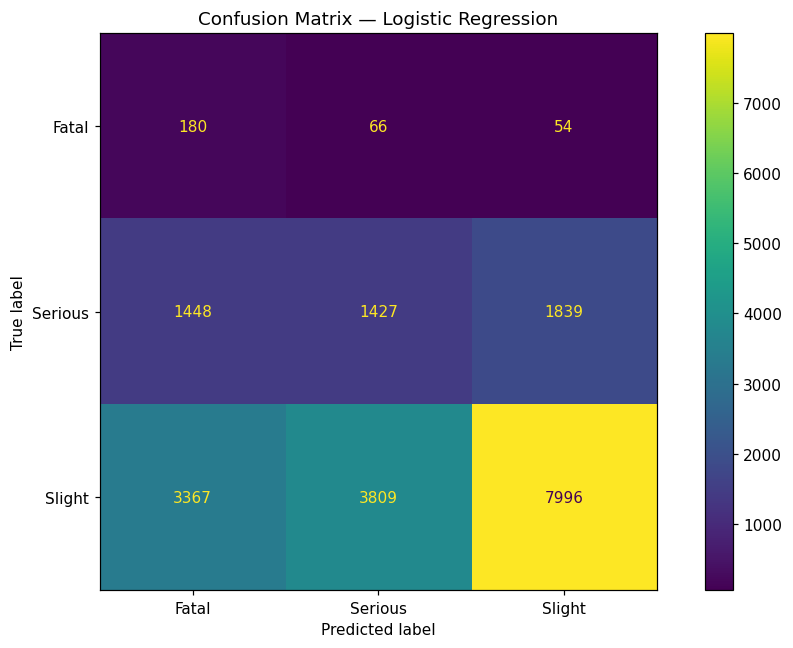

In [42]:

# --- STEP 5: Model 1 — Logistic Regression (class-weighted) ---
log_reg = LogisticRegression(max_iter=2000, multi_class='multinomial', class_weight='balanced')

pipe_lr = Pipeline([
    ('preprocess', preprocessor),
    ('model', log_reg)
])

pipe_lr.fit(X_train, y_train)
pred_lr = pipe_lr.predict(X_test)
print("=== Logistic Regression (class_weight='balanced') ===")
print(classification_report(y_test, pred_lr, target_names=['Fatal','Serious','Slight']))

cm_lr = confusion_matrix(y_test, pred_lr, labels=[1,2,3])
ConfusionMatrixDisplay(cm_lr, display_labels=['Fatal','Serious','Slight']).plot(values_format='d')
plt.title('Confusion Matrix — Logistic Regression')
plt.tight_layout(); plt.show()


=== Random Forest (class_weight='balanced_subsample') ===
              precision    recall  f1-score   support

       Fatal       0.02      0.24      0.04       300
     Serious       0.27      0.32      0.29      4714
      Slight       0.79      0.62      0.69     15172

    accuracy                           0.54     20186
   macro avg       0.36      0.39      0.34     20186
weighted avg       0.66      0.54      0.59     20186



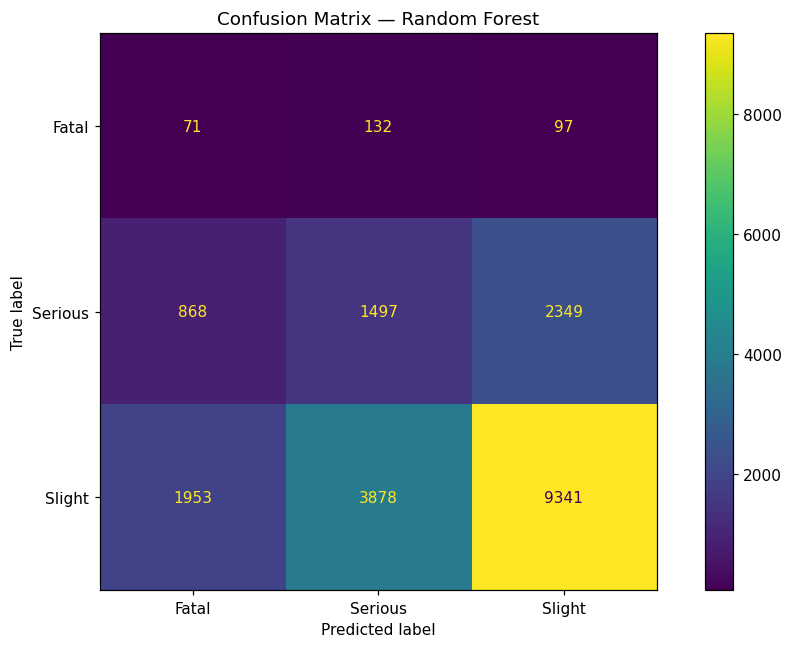

In [44]:

# --- STEP 6: Model 2 — Random Forest (class-weighted) ---
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)

pipe_rf = Pipeline([
    ('preprocess', preprocessor),
    ('model', rf)
])

pipe_rf.fit(X_train, y_train)
pred_rf = pipe_rf.predict(X_test)
print("=== Random Forest (class_weight='balanced_subsample') ===")
print(classification_report(y_test, pred_rf, target_names=['Fatal','Serious','Slight']))

cm_rf = confusion_matrix(y_test, pred_rf, labels=[1, 2, 3])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Fatal', 'Serious', 'Slight'])
disp_rf.plot(values_format='d')

plt.title("Confusion Matrix — Random Forest")
plt.tight_layout()
plt.show()



In [73]:

# --- STEP 7:  — Oversampling for imbalance ---
pipe_rf_os = ImbPipeline([
    ('preprocess', preprocessor),
    ('oversample', RandomOverSampler(random_state=42)),
    ('model', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
])
pipe_rf_os.fit(X_train, y_train)
pred_rf_os = pipe_rf_os.predict(X_test)
print("=== Random Forest + RandomOverSampler ===")
print(classification_report(y_test, pred_rf_os, target_names=['Fatal','Serious','Slight']))


=== Random Forest + RandomOverSampler ===
              precision    recall  f1-score   support

       Fatal       0.03      0.30      0.05       300
     Serious       0.27      0.33      0.29      4714
      Slight       0.80      0.57      0.66     15172

    accuracy                           0.51     20186
   macro avg       0.36      0.40      0.34     20186
weighted avg       0.66      0.51      0.57     20186



speed_limit                0.198893
number_of_vehicles         0.163180
number_of_casualties       0.133747
urban_or_rural_area_2.0    0.036264
urban_or_rural_area_1.0    0.031733
weather_conditions_1.0     0.028223
day_of_week_6.0            0.027046
day_of_week_5.0            0.026809
day_of_week_2.0            0.026638
day_of_week_3.0            0.026389
day_of_week_4.0            0.025426
light_conditions_1.0       0.025092
day_of_week_7.0            0.025070
weather_conditions_2.0     0.024840
day_of_week_1.0            0.024564
road_type_6.0              0.021535
light_conditions_4.0       0.021132
light_conditions_6.0       0.019707
road_type_3.0              0.017766
road_type_1.0              0.012320
dtype: float64

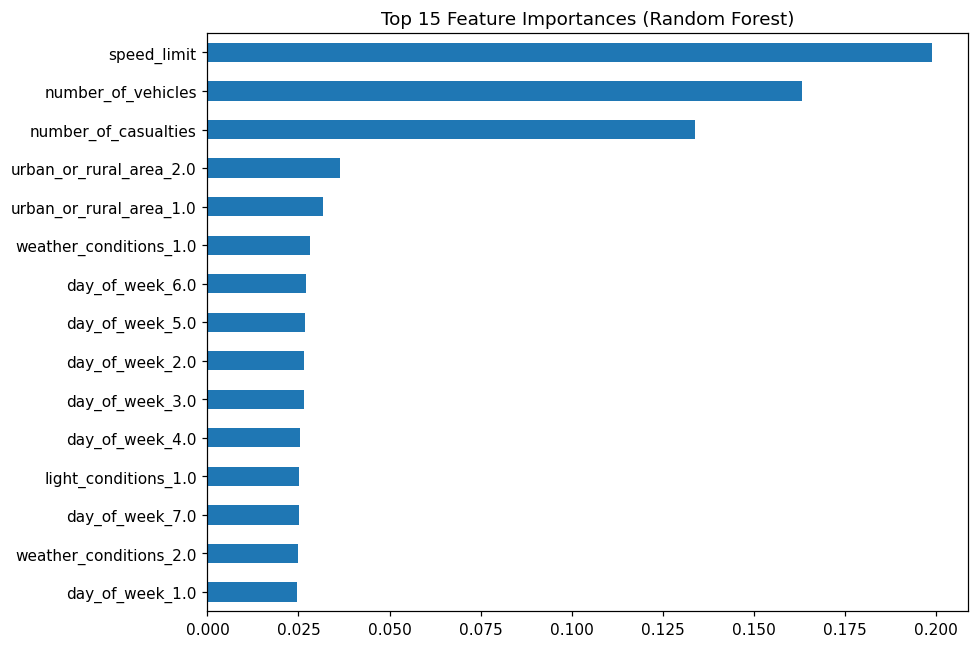

In [50]:

# Refit on train to ensure model exists
pipe_rf.fit(X_train, y_train)
# Get transformed feature names
oh = pipe_rf.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
cat_names = oh.get_feature_names_out(['weather_conditions','light_conditions','road_type','urban_or_rural_area','day_of_week'])
num_names = np.array(['speed_limit','number_of_vehicles','number_of_casualties'])
all_names = np.concatenate([num_names, cat_names])
importances = pipe_rf.named_steps['model'].feature_importances_
imp = pd.Series(importances, index=all_names).sort_values(ascending=False).head(20)
display(imp)

ax = imp.head(15).sort_values().plot(kind='barh')
ax.set_title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()
